# Introduction
## The Challenge
Named entity recognition (NER) is a fundamental task in Natural Language Processing (NLP) and one of the first stages in many language understanding tasks. It has drawn research attention for a few decades, and its importance has been well recognized in both academia and industry.
While NER is applied in many different settings, for this challenge, we will only be using eBay listing titles for NER. A few examples of NER labeling of listing titles are shown below (these examples are in English to illustrate the concept, the challenge data will have German language listing titles).

![image](https://i.ibb.co/y0rZk67/unnamed.png)

The extracted entities are also called aspects, and an aspect consists of the aspect name (“Brand name” for the first aspect in the last example above) and the aspect value (“NYX” for the same aspect in the same example above). The objective of this challenge then is to extract and label the aspects in the dataset of item titles listed on eBay. Not all titles have all aspects, and figuring out which aspect is present for a given title is part of the challenge.

## Data
The data set consists of 10 million randomly selected unlabeled item titles from eBay Germany, all of which are from “Athletic Shoes” categories. Among these item titles there are 10,000 labeled item titles (“labeled” means the aspects have been extracted). The 10,000 labeled item titles are split into three groups:

1. Training Set: Contains 5,000 records. I'm using this set to build and train my model/prediction system. It includes the actual aspects for each item title, along with their record numbers.

2. Quiz Set: Comprises 2,500 records and is used for leaderboard scoring in the competition. The aspects aren't provided for this set. Instead of the exact quiz records, I'm given a superset of 25,000 record identifiers, with the quiz titles being a subset of these.

3. Test Set: This set also has 2,500 records and is crucial for determining the competition winner. However, it's only available to the top-scoring teams after the competition ends on EvalAI on November 28th, 2023. Like the quiz set, the test set doesn't come with aspect values and is part of a larger superset of 25,000 record numbers.

My task is to accurately predict the aspects of the titles in the quiz and test sets using the model developed from the training set.

## My approach
My best and final submission, which received a f1-score of 93.1% across 34 categories on the quiz set, relies on a three-stage approach.
1. Deberta training: Pretraining the [multilingual Deberta transformer model](https://huggingface.co/microsoft/mdeberta-v3-base) on the unlabeled set of eBay titles.
2. Tagger training: Using the Flair NLP library to train a task-aware representation of sentences (TARS) tagger using Deberta vector embeddings learned in previous step.
3. Application: Applying the trained tagger to given data and making several manual adjustments to the tagging.


## Deberta training

I continued pretraining of the multilingual Deberta model mdeberta-v3-base on the corpus of unlabeled training data train.txt. This file contains 10 million eBay product titles; training on this data allows the Deberta transformer to better represent the tokens typical of this application. run_mlm.py is the command to pretrain a Huggingface transformer model. The following command was run on a L4 GPU via the Google Compute Engine platform; sensitive information such as Huggingface tokens is replaced with "xxx".

In [ ]:
!python3 ./examples/pytorch/language-modeling/run_mlm.py \
    --model_name_or_path microsoft/mdeberta-v3-base \
    --do_train \
    --do_eval \
    --train_file train.txt \
    --output_dir xxx \
    --token xxx \
    --push_to_hub True \
    --push_to_hub_token xxx \
    --evaluation_strategy epoch \
    --num_train_epochs 20

Below is a graph of the model training.

![Alt text](image.png)

## Flair

### Training data preprocessing
The labeled training data is provided in the following format:

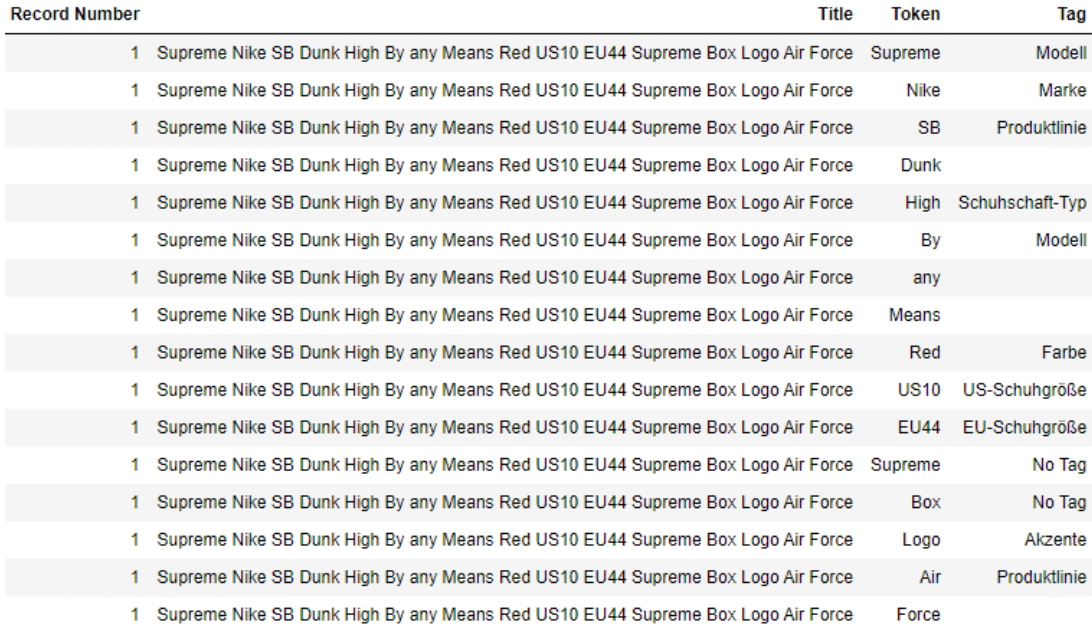

In order to use this data for a Flair Corpus, it has to be properly formatted, as shown below: 

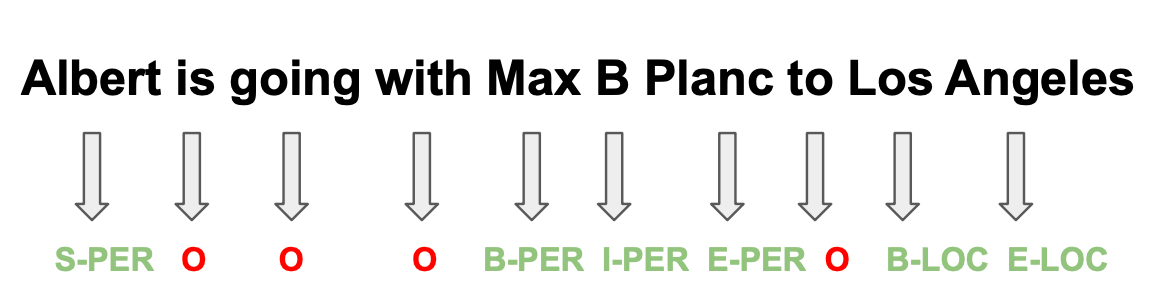

I format the training records into the [BIOES](https://medium.com/@muskaan.maurya06/name-entity-recognition-and-various-tagging-schemes-533f2ac99f52) format using the program below. This method of tagging tokens offers rich information about the positioning of tokens within entities.

In [ ]:
import pandas as pd
d = pd.read_csv('Train_Tagged_Titles.tsv', sep='\t', error_bad_lines=False)
grouped_data = d.groupby("Record Number")
with open('bioes.txt', 'w') as f:
  for i in range(1,5001):
      try:
          record = grouped_data.get_group(i)
      except:
          continue
      # entities = []
      start_index = 0
      end = -1
      prev_label = ""

      for i, (index, row) in enumerate(record.iterrows()):
          title = row["Title"]
          start = end+1
          end = start + len(row["Token"])
          label = row["Tag"]
          word = title[start:end]

          if label == 'No Tag' or label == 'Obscure':
            descriptor = "O"

          elif pd.notna(label):
            if (i == len(record)-1 or pd.notna(record.loc[index+1]["Tag"])):
              descriptor = "S-" + label

            else:
              descriptor = "B-" + label

          else:
            if i == len(record) -1 or pd.notna(record.loc[index+1]["Tag"]):
              descriptor = "E-" + prev_label

            else:
              descriptor = "I-" + prev_label

          line = word + "ñ" + descriptor + '\n'
          f.write(line)
          prev_label = label if pd.notna(label) else prev_label

      f.write('\n')

      #     if pd.notna(label):
      #         entities.append([start, end, label])
      #     else:
      #       if entities:
      #         to_modify = entities.pop()
      #         start = to_modify[0]
      #         end = to_modify[1] + 1 + len(row["Token"])
      #         label = to_modify[2]
      #         entities.append([start, end, label])
      #       else:
      #         print(index)

      # TRAIN_DATA.append([title, {"entities": entities}])

Here is a sample of what this data looks like:

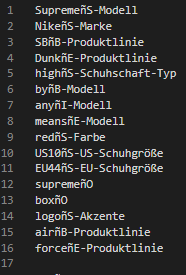


I then split this data up into three datasets:
* Train: 3435 examples
* Test: 859 examples
* Dev: 210 examples

These files were named train.txt, test.txt, and dev.txt respectively, and were used as input in the next step.

### Flair training
The following code was also run on a Google Compute Engine instance with a L4 GPU. This code uses the model previously trained and uploaded to Huggingface to train a Flair TARSTagger. 

In [ ]:
from flair.data import Corpus
from flair.models import TARSTagger, FewshotClassifier
from flair.data import Sentence
from flair.trainers import ModelTrainer
from flair.datasets import ColumnCorpus
columns = {0 : 'text', 1 : 'ner'}

# directory where the data resides
data_folder = './'
# initializing the corpus
corpus = ColumnCorpus(data_folder, columns, train_file = 'train.txt', test_file = 'test.txt', dev_file = 'dev.txt', column_delimiter='ñ')

# 3. what label do you want to predict?
label_type = 'ner'

# 4. make a label dictionary
label_dict = corpus.make_label_dictionary(label_type=label_type, add_unk=True)
#label_dict.remove_item("")
# 5. start from our existing TARS base model for English
#tars = TARSClassifier.load("tars-base")

# 5a: alternatively, comment out previous line and comment in next line to train a new TARS model from scratch instead
tars: FewshotClassifier = TARSTagger(embeddings="path-to-my-huggingface-deberta")

# 6. switch to a new task (TARS can do multiple tasks so you must define one)
tars.add_and_switch_to_new_task(task_name="Named Entity Recognition on German eBay product listings",
                                label_dictionary=label_dict,
                                label_type=label_type,
                                )

# 7. initialize the text classifier trainer
trainer = ModelTrainer(tars, corpus)

# 8. start the training
trainer.train(base_path='resources/taggers/deberta-tars',  # path to store the model artifafcts
              learning_rate=0.02,  # use very small learning rate
              mini_batch_size=16,
              mini_batch_chunk_size=4,  # optionally set this if transformer is too much for your machine (I had to do this)
              max_epochs=100,  # terminate after 100 epochs
              train_with_dev=True)

## Application of tagger
The final step is to apply the trained tagger to the input file of unlabeled data. The code for this is shown below.

In addition, by closely examining the data files, I was able to make two manual adjustments to the labels that improved my f1-score. Other adjustments were tried, such as more manual labeling of Jahreszeit (season), but only the two in the final code lead to an improvement.

In [26]:
import csv
from flair.data import Sentence
from flair.models import SequenceTagger
import pathlib
temp = pathlib.PosixPath
pathlib.PosixPath = pathlib.WindowsPath
from flair.models import TARSTagger

model = TARSTagger.load('./deberta-tars.pt')
data2 = pd.read_csv('titles-quiz-out.csv', error_bad_lines=False)
readback2 = pd.read_csv('quiz-titles.csv', sep='\t', header=None)
approved_ents = set(["Abteilung", "Aktivität", "Akzente", "Anlass", "Besonderheiten", "Charakter", "Charakter Familie", "Dämpfungsgrad", "Erscheinungsjahr", "EU-Schuhgröße", "Farbe", "Futtermaterial", "Gewebeart", "Herstellernummer", "Herstellungsland und -region", "Innensohlenmaterial", "Jahreszeit", "Laufsohlenmaterial", "Marke", "Maßeinheit", "Modell", "Muster", "Obermaterial", "Produktart", "Produktlinie", "Schuhschaft-Typ", "Schuhweite", "Stil", "Stollentyp", "Thema", "UK-Schuhgröße", "US-Schuhgröße", "Verschluss", "Zwischensohlen-Typ"])

with open('./submission-flair-deberta-tars.tsv', 'w', newline='') as tsvfile:
    writer = csv.writer(tsvfile, delimiter='\t', lineterminator='')
    for i in range(1, 25001):
        text = data2.iloc[i]["Title"]
        lowertext = text
        sentence = Sentence(lowertext)
        model.predict(sentence)
        start = 0
        for label in sentence.labels:
            if label.value in approved_ents:
                start_ind = label.data_point.start_position
                ent_length = len(label.data_point.text)
                original_cap = readback2.iloc[i+5000]["Title"][start_ind:start_ind + ent_length]
                start = start_ind + ent_length
                
                to_write = label.value
                
                if label.value == "Abteilung": # remove these because small tokens that are not specific fixed ones are extraneous
                    if (len(original_cap) == 1 and original_cap.lower() not in ["m", "w", "f"]) or (len(original_cap) == 2 and original_cap.lower() not in ["gs", "wm", "wn", "mn", "ws", "jr", "ms"]) or any([x in original_cap for x in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']]):
                        continue

                if original_cap in ["1/3", "1/2", "2/3"] and to_write in ["EU-Schuhgröße", "US-Schuhgröße", "UK-Schuhgröße"]:
                    writer.writerow(['\t' + original_cap]) # write the shoesize fraction to the same type of shoe size as the preceding whole number
                
                else:
                    tsvfile.write('\n')
                    writer.writerow([i+5000, to_write, original_cap])

## Other attempts
I tried a nearly-identical approach with several other transformers:
* [Roberta](https://huggingface.co/konstantindobler/xlm-roberta-base-focus-german)
* [Electra](https://huggingface.co/stefan-it/electra-base-gc4-64k-1000000-cased-generator)
* [Bert German/English bilingual](https://huggingface.co/igorsterner/german-english-code-switching-bert)
* [Bert German Base](https://huggingface.co/bert-base-german-cased)

In addition, I experimented with the SpaCY NLP library for tagger training. The code and results of these experiments will be pushed to this page.